# GRW Results (Figure 5) used in the manuscript:
### Song, Z., & Jiang, Z. (2023). A Novel Data-driven Numerical Method for Hydrological Modeling of Water Infiltration in Porous Media. arXiv preprint arXiv:2310.02806


### Senario 1

Total execution time: 62.9932816028595


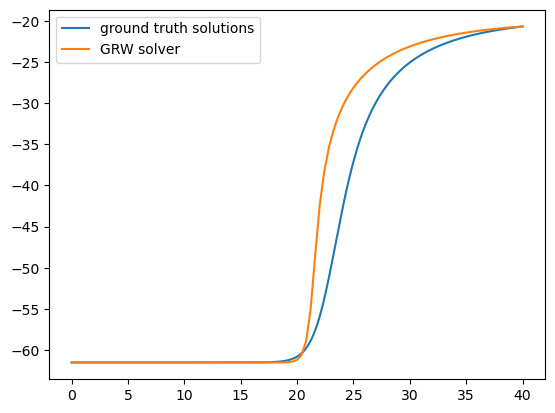

In [1]:
import math
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from correlations import theta, calculate_K, calculate_K_prime
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
np.seterr(divide='ignore', invalid='ignore')
def main():
    start_time = time.time()
    
    
    # Define parameters
    Total_time=360
    K_s=9.44e-03
    theta_r=0.075
    theta_s=0.287
    alpha=1.611e06
    A=1.175e06
    beta=3.96
    gama=4.74
    maxr=0.8
    num_nodes=101
    initial_depth=0
    end_depth=40
    dz=(end_depth-initial_depth)/(num_nodes-1)
    iterations=10000
    tolerance=3.2e-5
    number_of_praticles=1e10
    current_time=0 
    t_num=1
    boundary_residual_start=0
    boundary_residual_end=0 
    grid_z=np.arange(initial_depth,end_depth+dz,dz)
    
    # Define initial conditions
    psi_0=-61.5*np.ones(num_nodes)
    n0=number_of_praticles*psi_0
    soil_moisture_content= np.ones(num_nodes)
    n=n0
    L=3*np.ones(num_nodes)
    init_num_particles=n[0]
    psi=psi_0
    n=n0
    
    # Calculate theta
    for num in range(0,num_nodes):
        soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta)
    soil_moisture_content_0=soil_moisture_content
    psi_current=psi

   

    # Define and initialize necessary arrays   
    c=0
    flux_residual= np.zeros(num_nodes-2)
    K= np.ones(num_nodes-1)
    second_term= np.zeros(num_nodes-2)
    q= np.zeros(num_nodes-1)
    r=np.zeros(num_nodes-1)
    residual_coefficients= np.zeros(num_nodes)
    first_term= np.zeros(num_nodes)
    soil_moisture_content_diff=np.ones(num_nodes)
    g=np.zeros(num_nodes)
    h=np.zeros(num_nodes)

    # Simulation starts here:
    while current_time<=Total_time:
        for num in range(0,num_nodes-1):
            K[num]=calculate_K(psi[num],K_s,A,gama)
            dt=(np.power(dz,2)*maxr)/(2*max(K))
        tol_iterations=np.zeros(iterations)
        for iteration in range(0,iterations):
            for num in range(0,num_nodes-1):
                K[num]=calculate_K(psi[num],K_s,A,gama)
                dt=(np.power(dz,2)*maxr)/(2*max(K))
        ####################################################################################
        # Calculate the coefficients of the first term
        ####################################################################################
        
            for num in range(0,num_nodes-1):
                r[num]=dt*K[num]/((max(abs(L)))*math.pow(dz,2)); #random walk r
                residual_coefficients[0]=1-2*r[0]
            for num in range(1,num_nodes-1):
                residual_coefficients[num]=1-(r[num-1]+r[num])
                residual_coefficients[num_nodes-1]=1-2*r[num_nodes-2]
        
        ########################################################################################
        # Calculate the first term
        #########################################################################################
        
            for num in range(1,num_nodes):
                first_term[num]=residual_coefficients[num]*n[num]#+restr[num-1]
                first_term[0]=residual_coefficients[0]*n[0];
            first_term_adjustment=np.floor(first_term)
            new_number_of_particles=first_term_adjustment
            saturation_adjustment=n-new_number_of_particles
            boundary_residual_start=r[0]*n[0]
            saturation_adjustment_start=np.floor(boundary_residual_start)
            new_number_of_particles[1]=new_number_of_particles[1]+saturation_adjustment_start
        
        #########################################################################################
        # Calculate the second term
        #########################################################################################
        
            for num in range(0,num_nodes-2):
                second_term[num]=r[num]*n[num+1]
            second_term_adjustment=np.floor(second_term)
            for num in range(0,num_nodes-2):
                new_number_of_particles[num] +=second_term_adjustment[num]
                new_number_of_particles[num+2]=new_number_of_particles[num+2]+saturation_adjustment[num+1]-second_term_adjustment[num];
            boundary_residual_end=r[num_nodes-2]*n[num_nodes-1]+boundary_residual_end 
            end_saturation_adjustment=np.floor(boundary_residual_end)
            boundary_residual_end=boundary_residual_end-end_saturation_adjustment
            new_number_of_particles[num_nodes-2]=new_number_of_particles[num_nodes-2]+end_saturation_adjustment 
            new_number_of_particles[0]=init_num_particles
            new_number_of_particles[num_nodes-1]=-20.7*number_of_praticles
            
        #############################################################################################   
        # Calculate the third term 
        #############################################################################################
        
            for num in range(0,num_nodes):
                soil_moisture_content_diff[num]=(soil_moisture_content[num]-soil_moisture_content_0[num])/max(abs(L))
            third_term_init=np.diff(r)*dz
            for num in range(0,num_nodes-2):
                third_term_init[num]=third_term_init[num]-soil_moisture_content_diff[num+1] 
            
            flux_residual=number_of_praticles*third_term_init
            third_term=np.floor(flux_residual)
            
        ########################################################################################    
        # Calculate RHS: n^(s+1) 
        ########################################################################################
        
            for num in range(1,num_nodes-1):
                new_number_of_particles[num]=new_number_of_particles[num]+third_term[num-1]
            n=new_number_of_particles
            
        ######################################################################################
        # Map n^(s+1) to psi^(s+1) 
        ######################################################################################
        
            psi=n/number_of_praticles
            tol_iteration=np.linalg.norm(psi-psi_current)/np.linalg.norm(psi)
            
        #######################################################################################    
        # Condition of static L-scheme
        #######################################################################################
            
            if t_num*0.2*Total_time>=current_time and t_num*0.2*Total_time<current_time+dt: 
                tol_iterations[iteration]=tol_iteration
            if tol_iteration <= tolerance:
                break  
            for num in range(0,num_nodes):
                soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta)      
            psi_current=psi;
            if  t_num*0.2*Total_time>=current_time and t_num*0.2*Total_time<current_time+dt: 
                t_num+=1
            for num in range(0,num_nodes):
                soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta) 
               
            for num in range(0,num_nodes-1):
                q[num]=-K[num]*((psi[num+1]-psi[num])/dz+1)
        c+=1
        current_time+=dt
    end_time = time.time()
    print("Total execution time:", end_time - start_time)
    ground_truth=np.loadtxt(open("ground_truth_solutions.csv"))
    grid_gt= np.arange(0,40.1,0.1)
    plt.plot(grid_gt,ground_truth)
    plt.plot(grid_z,psi)
    plt.legend(['ground truth solutions','GRW solver'], loc='upper left')
    plt.show
   
if __name__ == "__main__":
    main()

### Scenario 2

Total execution time: 33.312424421310425


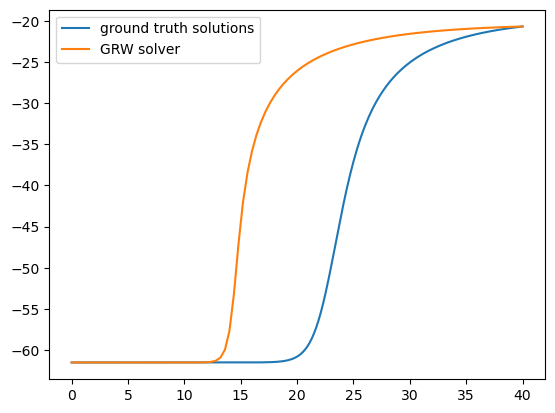

In [2]:
import math
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from correlations import theta, calculate_K, calculate_K_prime
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
np.seterr(divide='ignore', invalid='ignore')
def main():
    start_time = time.time()
    
    
    # Define parameters
    Total_time=360
    K_s=9.44e-03
    theta_r=0.075
    theta_s=0.287
    alpha=1.611e06
    A=1.175e06
    beta=3.96
    gama=4.74
    maxr=0.8
    num_nodes=101
    initial_depth=0
    end_depth=40
    dz=(end_depth-initial_depth)/(num_nodes-1)
    iterations=500
    tolerance=1e-10
    number_of_praticles=1e10
    current_time=0 
    t_num=1
    boundary_residual_start=0
    boundary_residual_end=0 
    grid_z=np.arange(initial_depth,end_depth+dz,dz)
    
    # Define initial conditions
    psi_0=-61.5*np.ones(num_nodes)
    n0=number_of_praticles*psi_0;
    soil_moisture_content= np.ones(num_nodes)
    n=n0;
    L=1*np.ones(num_nodes)
    init_num_particles=n[0]
    psi=psi_0
    n=n0
    
    # Calculate theta
    for num in range(0,num_nodes):
        soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta)
    soil_moisture_content_0=soil_moisture_content
    psi_current=psi

   

    # Define and initialize necessary arrays   
    c=0
    flux_residual= np.zeros(num_nodes-2)
    K= np.ones(num_nodes-1)
    second_term= np.zeros(num_nodes-2)
    q= np.zeros(num_nodes-1)
    r=np.zeros(num_nodes-1)
    residual_coefficients= np.zeros(num_nodes)
    first_term= np.zeros(num_nodes)
    soil_moisture_content_diff=np.ones(num_nodes)
    g=np.zeros(num_nodes)
    h=np.zeros(num_nodes)

    # Simulation starts here:
    while current_time<=Total_time:
        for num in range(0,num_nodes-1):
            K[num]=calculate_K(psi[num],K_s,A,gama);
            dt=(np.power(dz,2)*maxr)/(2*max(K));
        tol_iterations=np.zeros(iterations);
        for iteration in range(0,iterations):
            for num in range(0,num_nodes-1):
                K[num]=calculate_K(psi[num],K_s,A,gama);
                dt=(np.power(dz,2)*maxr)/(2*max(K));
        ####################################################################################
        # Calculate the coefficients of the first term
        ####################################################################################
        
            for num in range(0,num_nodes-1):
                r[num]=dt*K[num]/((max(abs(L)))*math.pow(dz,2)); #random walk r
                residual_coefficients[0]=1-2*r[0];
            for num in range(1,num_nodes-1):
                residual_coefficients[num]=1-(r[num-1]+r[num]);
                residual_coefficients[num_nodes-1]=1-2*r[num_nodes-2];
        
        ########################################################################################
        # Calculate the first term
        #########################################################################################
        
            for num in range(1,num_nodes):
                first_term[num]=residual_coefficients[num]*n[num]#+restr[num-1];
                first_term[0]=residual_coefficients[0]*n[0];
            first_term_adjustment=np.floor(first_term)
            new_number_of_particles=first_term_adjustment
            saturation_adjustment=n-new_number_of_particles
            boundary_residual_start=r[0]*n[0]
            saturation_adjustment_start=np.floor(boundary_residual_start)
            new_number_of_particles[1]=new_number_of_particles[1]+saturation_adjustment_start
        
        #########################################################################################
        # Calculate the second term
        #########################################################################################
        
            for num in range(0,num_nodes-2):
                second_term[num]=r[num]*n[num+1]
            second_term_adjustment=np.floor(second_term)
            for num in range(0,num_nodes-2):
                new_number_of_particles[num] +=second_term_adjustment[num]
                new_number_of_particles[num+2]=new_number_of_particles[num+2]+saturation_adjustment[num+1]-second_term_adjustment[num];
            boundary_residual_end=r[num_nodes-2]*n[num_nodes-1]+boundary_residual_end 
            end_saturation_adjustment=np.floor(boundary_residual_end)
            boundary_residual_end=boundary_residual_end-end_saturation_adjustment
            new_number_of_particles[num_nodes-2]=new_number_of_particles[num_nodes-2]+end_saturation_adjustment 
            new_number_of_particles[0]=init_num_particles
            new_number_of_particles[num_nodes-1]=-20.7*number_of_praticles
            
        #############################################################################################   
        # Calculate the third term 
        #############################################################################################
        
            for num in range(0,num_nodes):
                soil_moisture_content_diff[num]=(soil_moisture_content[num]-soil_moisture_content_0[num])/max(abs(L))
            third_term_init=np.diff(r)*dz
            for num in range(0,num_nodes-2):
                third_term_init[num]=third_term_init[num]-soil_moisture_content_diff[num+1] 
            
            flux_residual=number_of_praticles*third_term_init
            third_term=np.floor(flux_residual)
            
        ########################################################################################    
        # Calculate RHS: n^(s+1) 
        ########################################################################################
        
            for num in range(1,num_nodes-1):
                new_number_of_particles[num]=new_number_of_particles[num]+third_term[num-1]
            n=new_number_of_particles
            
        ######################################################################################
        # Map n^(s+1) to psi^(s+1) 
        ######################################################################################
        
            psi=n/number_of_praticles
            tol_iteration=np.linalg.norm(psi-psi_current)/np.linalg.norm(psi)
            
        #######################################################################################    
        # Condition of static L-scheme
        #######################################################################################
            
            if t_num*0.2*Total_time>=current_time and t_num*0.2*Total_time<current_time+dt: 
                tol_iterations[iteration]=tol_iteration
            if tol_iteration <= tolerance:
                break  
            for num in range(0,num_nodes):
                soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta)      
            psi_current=psi;
            if  t_num*0.2*Total_time>=current_time and t_num*0.2*Total_time<current_time+dt: 
                t_num+=1
            for num in range(0,num_nodes):
                soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta) 
               
            for num in range(0,num_nodes-1):
                q[num]=-K[num]*((psi[num+1]-psi[num])/dz+1)
        c+=1
        current_time+=dt
    end_time = time.time()
    print("Total execution time:", end_time - start_time)
    ground_truth=np.loadtxt(open("ground_truth_solutions.csv"))
    grid_gt= np.arange(0,40.1,0.1)
    plt.plot(grid_gt,ground_truth)
    plt.plot(grid_z,psi)
    plt.legend(['ground truth solutions','GRW solver'], loc='upper left')
    plt.show
   
if __name__ == "__main__":
    main()